# Low-Rank Gromov-Wasserstein

We try in this colab the low-rank (LR) Gromov-Wasserstein Solver, proposed by [Scetbon et. al'21b](https://arxiv.org/abs/2106.01128), a follow up to the LR Sinkhorn solver in [Scetbon et. al'21a](http://proceedings.mlr.press/v139/scetbon21a/scetbon21a.pdf).


In [1]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [317]:
def create_points(rng, n, m, d1, d2):
  rngs = jax.random.split(rng, 5)
  x = jax.random.uniform(rngs[0], (n, d1))
  y = jax.random.uniform(rngs[1], (m, d2))
  a = jax.random.uniform(rngs[2], (n,))
  b = jax.random.uniform(rngs[3], (m,))
  a = a / jnp.sum(a)
  b = b / jnp.sum(b)
  z = jax.random.uniform(rngs[4], (m, d1))
  return x, y, a, b, z

rng = jax.random.PRNGKey(0)
n, m, d1, d2 = 24, 17, 2, 3
x, y, a, b, z = create_points(rng, n, m, d1, d2)

Create two toy point clouds of heterogeneous size, and add a third geometry to provide a fused problem (see [Vayer et al.'20](https://www.mdpi.com/1999-4893/13/9/212)).


In [320]:
geom_xx = ott.geometry.pointcloud.PointCloud(x)
geom_yy = ott.geometry.pointcloud.PointCloud(y)
geom_xy = ott.geometry.pointcloud.PointCloud(x, z)  # here z is there only to create n x m geometry
prob = ott.core.quad_problems.QuadraticProblem(geom_xx, geom_yy, geom_xy=geom_xy, a=a, b=b)

Solve the problem using the Low-Rank Sinkhorn solver.

In [364]:
solver = ott.core.gromov_wasserstein.GromovWasserstein(rank=6)
ot_gwlr = solver(prob)

Run it with entropic-GW for the sake of comparison

In [360]:
solver = ott.core.gromov_wasserstein.GromovWasserstein(epsilon=0.05)
ot_gw = solver(prob)

One can notice that their outputs are quantitatively similar.

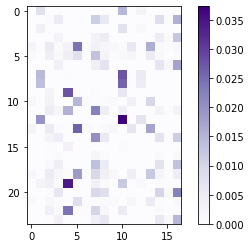

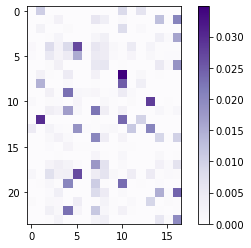

In [365]:
plt.imshow(ot_gwlr.matrix, cmap='Purples')
plt.colorbar()
plt.show()

plt.imshow(ot_gw.matrix, cmap='Purples')
plt.colorbar()
plt.show()

In [367]:
print(jnp.linalg.norm(ot_gwlr.transport-ot_gw.transport))

0.050668646
